In [1]:
import pandas as pd
import numpy as np

import polars as pl
import pyarrow

import xgboost as xgb
import sklearn

from src.feature_engineering import Features 


In [2]:
df = pl.read_csv("data/ifsc_boulder_results.csv")

df = Features.add_features(df)

cols_to_remove = [
    'round',
    'score',
    'round_rank'
]

df = df.drop(cols_to_remove).unique()

df.sample(5)

added features: ['events_last_year', 'athlete_age_in_days', 'is_on_podium', 'progression_to_semi_last_year', 'semis_last_year', 'finals_last_year', 'fra_athletes_count', 'podiums_last_year', 'athlete_years_active', 'jpn_athletes_count', 'avg_rank_last_year', 'is_janja_competing', 'progression_to_final_last_year']


event_id,event_name,dcat_id,dcat,status_as_of,athlete_id,athlete_name,athlete_country,comp_rank,comp_id,birthday,gender,first_season,height,arm_span,athlete_age_in_days,athlete_years_active,is_on_podium,jpn_athletes_count,fra_athletes_count,is_janja_competing,events_last_year,podiums_last_year,finals_last_year,semis_last_year,avg_rank_last_year,progression_to_semi_last_year,progression_to_final_last_year
i64,str,i64,str,date,i64,str,str,f64,i64,date,str,u32,f64,f64,i64,i64,u8,u32,u32,u8,u32,u32,i64,i64,f64,f64,f64
1238,"""IFSC - Climbing World Cup (B,L…",3,"""BOULDER Men""",2022-06-23,1929,"""Duffy Colin""","""USA""",1.0,12383,2003-12-10,"""male""",2017,170.0,null,6770,5,1,8,4,0,5,0,1,3,13.444444,0.6,0.2
1294,"""IFSC World Cup Salt Lake City …",7,"""BOULDER Women""",2023-05-21,11479,"""Storå Regine""","""NOR""",51.0,12947,2001-12-05,"""female""",2019,null,null,7837,4,0,7,5,0,3,0,0,0,67.0,0.0,0.0
1297,"""IFSC World Cup Innsbruck 2023""",7,"""BOULDER Women""",2023-06-15,4002,"""Shiran Noa""","""ISR""",41.0,12977,2001-11-30,"""female""",2015,174.0,null,7867,8,0,7,4,1,4,0,0,1,23.0,0.25,0.0
1410,"""IFSC World Cup Prague 2025""",7,"""BOULDER Women""",2025-06-12,1438,"""SMETANOVA Michaela""","""CZE""",43.0,14107,2003-02-03,"""female""",2017,165.0,null,8165,8,0,6,5,0,1,0,0,0,27.0,0.0,0.0
1233,"""IFSC - Climbing World Cup (B) …",3,"""BOULDER Men""",2022-04-10,2291,"""Takata Tomoaki""","""JPN""",14.0,12333,1995-02-20,"""male""",2012,175.0,null,9911,10,0,9,6,0,5,1,1,3,12.777778,0.6,0.2


In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

In [4]:
df.shape

(4007, 28)

In [5]:
[c for c in df.columns if c not in categorical_features]

NameError: name 'categorical_features' is not defined

In [6]:
target = 'is_on_podium'

categorical_features = [
    'dcat',
    'athlete_id', 
    'athlete_country', 
    'gender'
]

numerical_features = [
    'height',
    'athlete_age_in_days',
    'athlete_years_active',
    'jpn_athletes_count',
    'fra_athletes_count',
    'is_janja_competing',
    'events_last_year',
    'podiums_last_year',
    'finals_last_year',
    'semis_last_year',
    'avg_rank_last_year',
    'progression_to_semi_last_year',
    'progression_to_final_last_year'
]

features = categorical_features + numerical_features

In [7]:
df.filter(is_on_podium = 0).shape[0] / df.filter(is_on_podium = 1).shape[0]

24.685897435897434

In [40]:
encoder = OneHotEncoder(
    drop='first', 
    handle_unknown='ignore',
    sparse_output=False,
)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', encoder, categorical_features)
    ],
    remainder='passthrough',  # keeps numerical columns like 'weight'
)

preprocessor.set_output(transform="polars")

clf = xgb.XGBClassifier(
    eval_metric = 'aucpr',
    scale_pos_weight = 24.6 # sum(neg) / sum(pos)
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf)
])

X = df.select(features)
y = df.select(target)

cut_date = date(2024,12,1)
cond = pl.col('status_as_of') < cut_date
X_train = df.filter(cond).select(features)
y_train = df.filter(cond).select(target)
X_test = df.filter(~cond).select(features)
y_test = df.filter(~cond).select(target)

model = pipeline.fit(X_train, y_train)

test_preds = model.predict(X_test)

# df = df.with_columns(prediction = preds)


/Users/majalarsen/Developer/dev/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [59]:
1/(1+24.6)

0.0390625

In [14]:
preds = model.predict(X)

df = df.with_columns(prediction = preds)

In [24]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

In [41]:
accuracy_score(y_test.to_arrow(), test_preds)

0.9463869463869464

In [44]:
roc_auc_score(y_test.to_arrow(), test_preds)

0.7993714517437145

In [45]:
confusion_matrix(y_test.to_arrow(), test_preds)

array([[789,  33],
       [ 13,  23]])

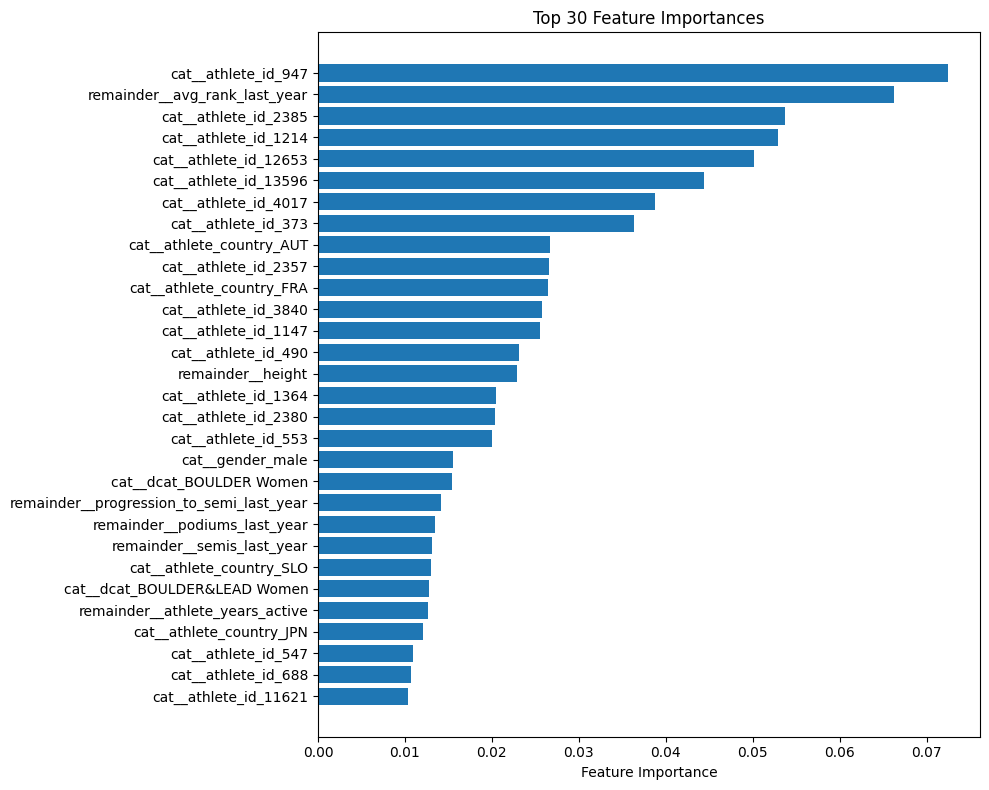

In [57]:
importances = pipeline.named_steps['classifier'].feature_importances_

feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

import matplotlib.pyplot as plt
import numpy as np

# Sort feature importances descending
indices = np.argsort(importances)[::-1]

# Limit to top 20 features
top_n = 30
top_indices = indices[:top_n]
top_features = np.array(feature_names)[top_indices]
top_importances = importances[top_indices]

plt.figure(figsize=(10, 8))
plt.title(f"Top {top_n} Feature Importances")

# Reverse order so highest importance is at top
plt.barh(range(top_n), top_importances[::-1], align='center')
plt.yticks(range(top_n), top_features[::-1])
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

In [58]:
df.filter(athlete_id = 947)

event_id,event_name,dcat_id,dcat,status_as_of,athlete_id,athlete_name,athlete_country,comp_rank,comp_id,birthday,gender,first_season,height,arm_span,athlete_age_in_days,athlete_years_active,is_on_podium,jpn_athletes_count,fra_athletes_count,is_janja_competing,events_last_year,podiums_last_year,finals_last_year,semis_last_year,avg_rank_last_year,progression_to_semi_last_year,progression_to_final_last_year,prediction
i64,str,i64,str,date,i64,str,str,f64,i64,date,str,u32,f64,f64,i64,i64,u8,u32,u32,u8,u32,u32,i64,i64,f64,f64,f64,i64
1237,"""IFSC - Climbing World Cup (B,S…",7,"""BOULDER Women""",2022-05-30,947,"""MORONI Camilla""","""ITA""",17.0,12377,2001-07-08,"""female""",2015,157.0,161.0,7631,7,0,6,1,0,6,1,3,5,8.0,0.833333,0.5,0
1405,"""IFSC World Cup Keqiao 2025""",7,"""BOULDER Women""",2025-04-19,947,"""MORONI Camilla""","""ITA""",27.0,14057,2001-07-08,"""female""",2015,157.0,161.0,8686,10,0,6,2,0,1,0,0,0,21.0,0.0,0.0,0
1301,"""IFSC World Championships Bern …",7,"""BOULDER Women""",2023-08-05,947,"""Moroni Camilla""","""ITA""",41.0,13017,2001-07-08,"""female""",2015,157.0,161.0,8063,8,0,5,5,1,5,0,0,4,15.444444,0.8,0.0,0
1297,"""IFSC World Cup Innsbruck 2023""",7,"""BOULDER Women""",2023-06-15,947,"""Moroni Camilla""","""ITA""",16.0,12977,2001-07-08,"""female""",2015,157.0,161.0,8012,8,0,7,4,1,5,0,0,4,14.777778,0.8,0.0,0
1291,"""IFSC World Cup Hachioji 2023""",7,"""BOULDER Women""",2023-04-22,947,"""Moroni Camilla""","""ITA""",18.0,12917,2001-07-08,"""female""",2015,157.0,161.0,7958,8,0,11,5,0,5,0,2,5,10.416667,1.0,0.4,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1292,"""IFSC World Cup Seoul 2023""",7,"""BOULDER Women""",2023-04-30,947,"""Moroni Camilla""","""ITA""",14.0,12927,2001-07-08,"""female""",2015,157.0,161.0,7966,8,0,7,5,0,6,0,2,6,11.5,1.0,0.333333,0
1353,"""IFSC World Cup Keqiao 2024""",7,"""BOULDER Women""",2024-04-09,947,"""Moroni Camilla""","""ITA""",2.0,13537,2001-07-08,"""female""",2015,157.0,161.0,8311,9,1,6,2,1,6,0,0,4,19.0,0.666667,0.0,1
1411,"""IFSC World Cup Bern 2025""",7,"""BOULDER Women""",2025-06-14,947,"""MORONI Camilla""","""ITA""",12.0,14117,2001-07-08,"""female""",2015,157.0,161.0,8742,10,0,5,6,0,5,1,1,3,12.333333,0.6,0.2,0
